# Fourier Transform

Start by importing the necessary math libs

In [455]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import Markdown as md
import numpy.linalg as lin

### Drawing a basic cosine wave

Let us start by drawing a basic cosine wave at a frequency as well as DC offset

In [456]:
a = 2 # Amplitude
freq = 5 # Frequency 
res = 0.01
phase = math.pi*(3/4)
theta = np.arange(0,2*np.pi,res)
theta = theta if len(theta) % 2 == 0 else theta[0:len(theta)-1] 
y = np.cos(freq*theta+phase)+a # Equation 
md("<h3>Cosine Properties:</h3>Amplitude is %3.3f<br>Frequency is %3.3f<br>Phase is %3.3f<br>Equation is: $y=cos(%3.3f \cdot \\theta + %3.3f)+%3.3f$"%(a,freq,phase,freq,phase,a))


<h3>Cosine Properties:</h3>Amplitude is 2.000<br>Frequency is 5.000<br>Phase is 2.356<br>Equation is: $y=cos(5.000 \cdot \theta + 2.356)+2.000$

### Next, plot the cosine

Y size is: (628,)


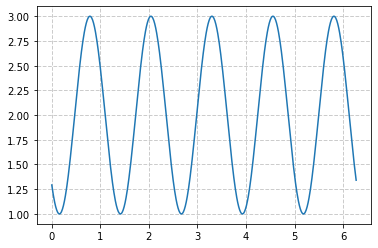

In [457]:
plt.plot(theta,y)
plt.grid(color='0.8', linestyle='--', linewidth=1)
print('Y size is: ' + str(np.shape(y)))

### Perform the FFFT and plot

(628,)
[ 2.27029619e-01-4.73311381e-02j  2.60320026e-01-1.08199090e-01j
  3.43590055e-01-2.13088527e-01j  6.16044389e-01-5.05693177e-01j
 -2.20203962e+02+2.23846895e+02j -5.11841637e-01+6.17350453e-01j
 -2.37982691e-01+3.30486654e-01j -1.48709684e-01+2.32495397e-01j
 -1.05322361e-01+1.82166053e-01j]


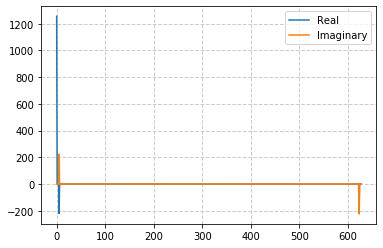

In [458]:
res = np.fft.fft(y)
print(np.shape(res))
print(res[1:10])
plt.plot(np.real(res))
plt.plot(np.imag(res))
plt.legend(['Real','Imaginary'])
plt.grid(color='0.8', linestyle='--', linewidth=1)


### Cleanup FFT

As observed, the output of the FFT is simply an array of complex numbers. However the frequency spikes are oddly disjointed. The later half of the FFT represents negative frequencies. This can either be trimmed off or it can be reflected along the axis

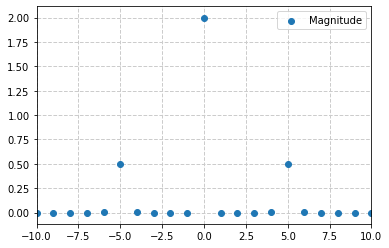

In [459]:
fig, ax = plt.subplots()
yfftr = np.real(res)
yr = res[0:int(len(res)/2)]
yi = res[int(len(res)/2):len(res)]
yfftr = np.concatenate([yi,yr]) #  Reflect negative signal portion 
x = np.arange(-int(len(res)/2),int(len(res)/2))/np.round(max(theta)/(2*np.pi)) # x axis is fractions of 2pi period. E.g. 
res_scaled = (np.real(yfftr)**2 + np.imag(yfftr)**2)**(1/2)/len(res) # Norm of signal 
ax.scatter(x,res_scaled)
ax.set_xlim(-10,10)
ax.grid(color='0.8', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
ax.legend(['Magnitude'])

### Retreive Amplitude, Phase, and Frequency from FFT

Amplitude = $\sqrt{Re(FFT)^2 + Im[FFT]^2)} $ <br>
Phase = Angle(FFT) <br>
Freq Step = N / 2*pi 

In [460]:
res_angle = np.angle(res)
res_amp = (np.real(res)**2 + np.imag(res)**2)**(1/2)/len(res)
res_freq = np.concatenate([np.round(max(theta)/(2*np.pi))*np.arange(0,int(len(res)/2)), np.round(max(theta)/(2*np.pi))*np.arange(-int(len(res)/2),0)])
fft_res = np.array([res_amp,res_angle,res_freq]).T
fft_sort = fft_res[fft_res[:,0].argsort()]
fft_sort = np.flipud(fft_sort)
print(np.shape(fft_sort))
print(fft_sort[:10]) 

(628, 3)
[[ 2.00034667e+00  0.00000000e+00  0.00000000e+00]
 [ 5.00003087e-01 -2.34799081e+00 -5.00000000e+00]
 [ 5.00003087e-01  2.34799081e+00  5.00000000e+00]
 [ 1.27697023e-03 -2.26302756e+00 -6.00000000e+00]
 [ 1.27697023e-03  2.26302756e+00  6.00000000e+00]
 [ 1.26913553e-03  6.87338434e-01 -4.00000000e+00]
 [ 1.26913553e-03 -6.87338434e-01  4.00000000e+00]
 [ 6.48496308e-04 -2.19488374e+00 -7.00000000e+00]
 [ 6.48496308e-04  2.19488374e+00  7.00000000e+00]
 [ 6.43794450e-04  5.55127517e-01 -3.00000000e+00]]


### Reconstruct original signal from a part of the FFT

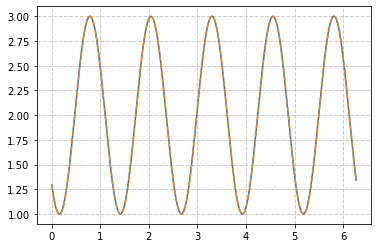

In [461]:
y_fft = np.ones([1,10]) @ (np.array([fft_sort[0:10,0]]).T * np.cos(np.array([fft_sort[0:10,2]]).T * theta + np.array([fft_sort[0:10,1]]).T  * (theta*0+1) )) 
y_fft = y_fft.flatten()
plt.plot(theta,y)
plt.plot(theta,y_fft,'--')
plt.grid(color='0.8', linestyle='--', linewidth=1)